# Iris Detection Model

## 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import time
import uuid

In [3]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Load Data

### 2.1 Collect Images

In [10]:
IMAGES_PATH = 'data\\images'
number_images = 80

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 2.2 Move Matching Labels AFTER Annotation with LabelMe

In [13]:
#First manually move images to respective train, test and val folders.
#The current chosen split is 70%-20%-10%
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### 2.3 Image Augmentations

In [14]:
import albumentations as alb

In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.4),
                         alb.RandomGamma(p=0.3),
                         alb.RGBShift(p=0.3),
                         alb.VerticalFlip(p=0.5)],
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels'])
    
)

In [27]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='RightEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='LeftEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='RightEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['RightEye','LeftEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 2.4 Load Images

In [28]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)  

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)\
                            .map(load_image)\
                            .map(lambda x: tf.image.resize(x, (250, 250)))\
                            .map(lambda x: x/255)  

### 2.5 Prepare Labels

In [30]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['keypoints']]

In [31]:
train_labels = tf.data.Dataset.list_files(r'aug_data\train\labels\*.json', shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files(r'aug_data\test\labels\*.json', shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files(r'aug_data\val\labels\*.json', shuffle=False)\
                            .map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.6 Combine Labels and Images

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(16).prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(5000).batch(16).prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(5000).batch(16).prefetch(4)

### 2.7 View Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


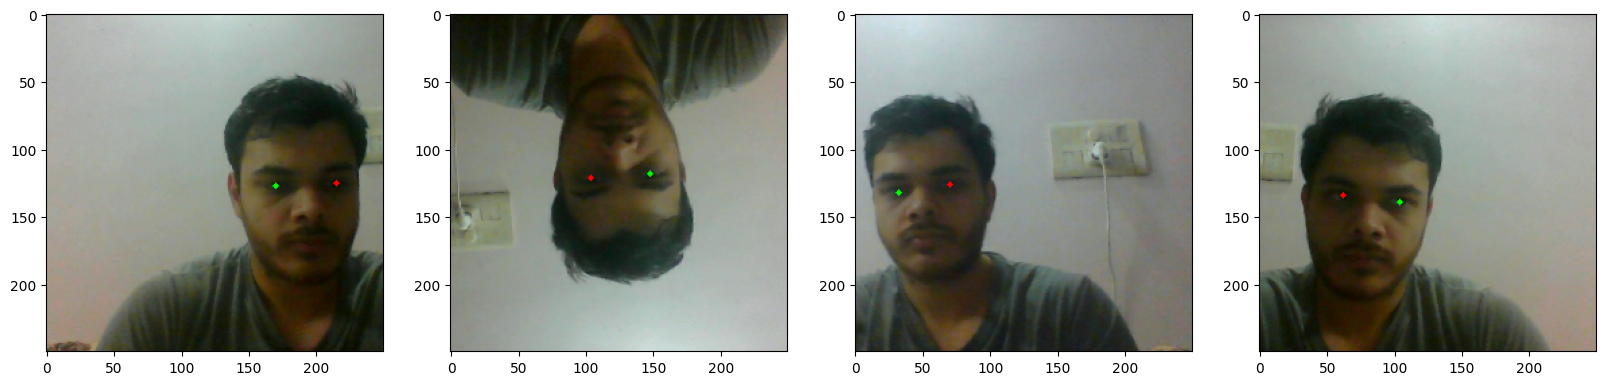

In [34]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    ax[idx].imshow(sample_image)

## 3. Build Model